<a href="https://colab.research.google.com/github/as9786/ML-DLPratice/blob/main/Pytorch/TransformerEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [1]:
import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras.datasets import imdb

# 장치 설정

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {}".format(device))

Using cuda


# Data

In [3]:
max_features = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
from tensorflow.keras.preprocessing import sequence
max_len = 200
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [5]:
# holdout
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.3)

In [6]:
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(x_train.shape))
print('Validation set: {}'.format(x_valid.shape))
print('Test set: {}'.format(x_test.shape))

Feature Shapes:
Train set: (17500, 200)
Validation set: (7500, 200)
Test set: (25000, 200)


In [7]:
from torch.utils.data import TensorDataset, DataLoader

In [8]:
train_dataset = TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
valid_dataset = TensorDataset(torch.from_numpy(x_valid),torch.from_numpy(y_valid))
test_dataset = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
# check our batches
dataiter = iter(train_loader)
x, y = next(dataiter)

In [11]:
print('Sample batch size: ', x.size())   # batch_size, seq_length
#print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
#print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 200])

Sample label size:  torch.Size([128])


# 모형

In [15]:
import numpy as np

In [17]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout=0.1, max_len = 200):
    super(PositionalEncoding,self).__init__()
    self.dropout = nn.Dropout(p=dropout)
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0,d_model,2).float()*(-np.log(10000.0)/d_model))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe',pe)

  def forward(self,x):
    x =  x + self.pe[:x.size(0),:]
    return self.dropout(x)

In [26]:
class TransformerEncoder(nn.Module):
  def __init__(self, max_features,embedding_dim, hidden_size, nheads, n_layers,max_len, num_labels,dropout):
    super(TransformerEncoder,self).__init__()
    self.embedding = nn.Embedding(max_features,embedding_dim)
    self.pe = PositionalEncoding(embedding_dim,max_len=max_len)
    enc_layer = nn.TransformerEncoderLayer(embedding_dim, nheads, hidden_size,dropout)
    self.encoder = nn.TransformerEncoder(enc_layer,num_layers=n_layers,)

    self.dense = nn.Linear(embedding_dim*max_len,num_labels)
    self.log_softmax = nn.LogSoftmax()

  def forward(self,x):
    x = self.embedding(x).permute(1,0,2)
    x = self.pe(x)
    x = self.encoder(x)
    x = x.reshape(x.shape[1],-1)
    x = self.dense(x)
    return x

In [27]:
model = TransformerEncoder(max_features,64,16,4,4,200,2,0.3).to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt

100%|██████████| 10/10 [01:19<00:00,  8.00s/it]


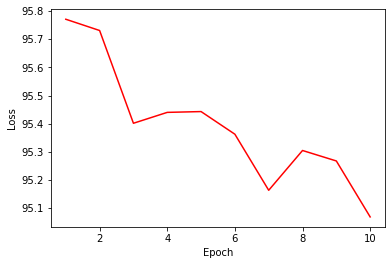

CPU times: user 1min 15s, sys: 194 ms, total: 1min 16s
Wall time: 1min 20s


In [32]:
%%time
loss_trace = []
for epoch in tqdm(range(10)):
  current_loss = 0
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(device), y.to(device)
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
  loss_trace.append(current_loss)

# loss curve
plt.plot(range(1, 11), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [33]:
correct, total = 0, 0
predictions = []
model.eval()
for i, (x,y) in enumerate(test_loader):

  with torch.no_grad():
    x, y  = x.to(device), y.to(device)
    outputs = model(x)
    _, y_pred = torch.max(outputs.data, 1)
    total += y.shape[0]
    correct += (y_pred == y).sum().item()

print(correct/total)

0.50268
